In [ ]:
#| echo: false
from matplotlib.patches import FancyArrowPatch
import nbdev
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as stats
from projective_simulation.methods import transforms

# Introducing Situated Projective Simulation 3.0

Bayesian state estimation provides a normative approach to updating ones beliefs about the state of the world. This approach, however, requires an accurate model of the transition probabilities between states and an accurate model of emission probabilities in each state (i.e. what the observer sees, or is likely to see). The real world is a massive, chaotic, open system; it is impossible that embodied agents navigating in that world come pre-equipped with such a model for all possible scenarios. The ability to learn such a model in unkown environments enables embodied agents to adapt to changing environments and almost certainly played a major role in the success of many animal species - most notably humans and other primates. Yet, it is not know *how* these embodied agents learn a model of the world that provides close-enough bayesian estimates of thier state, such that they can anticipate future scenarios. Episodic memory - the mental retrieval and replay of past events - appears to play an important role in how humans learn about the world and anticipate the future. Many animal also appear to rely on event-specific information retrieval to make adaptive decisions. While there is thus empirical evidence that episodic memory plays a role in mental model formation, it remains unclear how this process works. Situated Projective Simulatiom is a computational approach for understanding how episodic memory can be used to create and/or refine a mental model of the world through experience, such that the agent becomes able to make increasingly accurate predications about the future using Bayesian state estimation. SiPS also integrates insights from Active Inference, such that the agent not only learns to make better predictions, but to take actions that lead to a more predictable future.

In this document, I will introduce the various mechanisms of SiPS one-by-one. 

I begin with what I call the Bayesian Memory Network, which encodes memories in a graph struture with neural-network-like properties. This structure enables approximate bayesian state estimation even in the absence of a true world model by sampling from memories as a function of their excitation from the agent's current sensory state and an expectation that is passed forward through time by recurrent connections. This process is akin to Bayesian Filtering. We show how the computed surprise of the graph can be used as a reward signal for a system of conditioned reflexes, enabling learning in initially unknown Markov Decision Processes, and - to a lesser extent - certain Hidden Markov Decision Processes.

I then introduce the so-called Active Inference Memory Network, which expands on the Bayesian Memory Network by allowing the network to "prime" the agent's actions directly. This priming works in much the same way that the network sets expectations on sensory states, but in the case of actions these "priming" expectations are modulated by enocodings of how surprised the agent was in the sampled memory during which it previously took the action.

Finally, I discuss how the application of Projective Simulation - a deliberative model of decision making - to the Active Inference Memory Network may enable the agent to learn about conditional depencies between sensory states, to learn what components of its sensory signals are relevant and which are effectively noise, and to guide its actions by pro-actively imagining possible scenarios.

## The Bayesian Memory Network

Bayes' Theorem describes the probability of an event based on prior knowledge of conditions that might be related to the event. It is mathematically expressed as:

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Where:

- $ P(A \mid B) $ is the **posterior probability**: the probability of event $ A $ given that $ B $ has occurred.
- $ P(B \mid A) $ is the **likelihood**: the probability of event $ B $ given that $ A $ is true.
- $ P(A) $ is the **prior probability**: the initial probability of event $ A $.
- $ P(B) $ is the **marginal probability**: the total probability of event $ B $.

### State Estimation using a Fixed State Bayesian Network with Uncorrelated, Bit-wise Sensory Elements

To build an intuition for how we can implement Bayes' Theorem on a neural-network-like graph, let us consider a simple example. We are given two coins, a nickel and quarter (so we can tell them apart), but we are told there is a 50% chance these coins are biased. If they are biased, there is an 80% chance the quarter comes up heads and only a 30% chance the nickel does. Given that we flip each coin once and observe the result, Figure 1 illustrates how we can implement Bayes Theorem on a graph to determine the probability that the coins were biased - using the case where the quarter came up heads and the nickel came up tails. The nodes on the left can be thought of as our sensory representations of a head's up quarter and nickel, respectively. The excitation state of the first of these bitwise sensory elements, $\dot{s}_1$, is equal to 1 if we see a heads up quarter and 0 otherwise. Likewise for the nickel and the excitation state $\dot{s}_2$ of the second bitwise sensory element. For now, we can think of the nodes on the right as states in our mental model of the scenario. The weights of edges connecting sensory elements to states in the mental model give the probability of exciting the conneted sensory element when the true world state is represented by the connected node in the mental model. We can think of the excitation of sensory elements being passed along the edges to the mental model nodes, such that the excitation state of mental model nodes is the product of all of its inputs. Thus, the excitation state, $\dot{m}_\mathrm{j}$, of mental model node $j$ gives the joint likelihood of all excited (and unexcited) sensory elements, given the true world state $j$:

\begin{equation}
\dot{m}_\mathrm{j} = \prod_{\mathrm{i} = 1}^{\lvert\boldsymbol{S}\rvert} w_\mathrm{ij}^{\dot{s}_\mathrm{i}}(1-w_\mathrm{ij})^{1-\dot{s}_\mathrm{i}} = P(B \mid A = j),
\end{equation}

Where $\lvert S \rvert$ denotes the number of sensory elements and $B$, the event that has already occured, is given by $(\dot{s}_1, . . ., \dot{s}_{\lvert S \rvert})$.

![Bayesian Graph](Bayesian_Graph_Demo.png)
<figure>
<figcaption align = "center"> Figure 1: Example of a Bayesian Graph for a two bit system with two states. In one state, bit states, which we will think of as coin flips, are purely random (fair coins). In the second state, one bit is more likely to be on (heads up) and the other off (tails up). Nodes on the the left of the graph represent the bits, nodes on the right the states. Edges give the probability that the bit is on given the state.</figcaption>
</figure>

The prior probability of the two states in our mental model, $P(A)$, was given in the problem statement: 50% for each. We will notate the prior probability of the state represented in our mental model by a node $j$ as $\hat{m}_j$ and refer to it as the 'expectation'. To get the probability of our sensory state, $P(B)$, we simply need the sum of $P(B \mid A=j)P(A=j)$ for all nodes $j$ in our mental model. Thus

\begin{equation}
\tilde{m}_j = P(A=j \mid B) = \frac{P(B \mid A=j)P(A=j)}{P(B)} = \frac{\dot{m}_j\hat{m}_j}{\sum_{j'=1}^{\lvert M \rvert}\dot{m}_{j'}\hat{m}_{j'}},
\end{equation}

where $\tilde{m}_j$ is the activation of the node representing state $j$ in our mental model and $\lvert M \rvert$ is the number of states in our mental model. Note that that this operation is the same as normalizing the excitation-expectation-product across all mental model nodes.

Thus, we can describe the excitation of mental model nodes as a feed-forward operation on the Bayesian Network, parameterized by the prior probailities (i.e. expectation states) of the mental model nodes. This excitation gives the likelihood of the sensory state, given that the mental model node represents the true world state. We can then describe the activation state of a mental model node as the normalization of all mental model node excitations. Given that the Bayesian Graph is an accurate representation of the true world states, the activation state of a mental model node gives the probability that the node represents the true world state.


### Filtering using a Bayesian Network for State Estimation Given First Order Correlations In World State Sequences 

If the probabilities of transitioning from a given world state any other world state are known, the posterior probabilites of all states in the mental model can be used to determine prior probalities for those states in the future. For example, consider a simple case where it is known that coin flips alternate between the biased and unbiased states - as depicted in Figure 2. We can represent these transitions in a mental model by estblishing directed "clip edges" between mental model nodes (we will arrive at the reason for naming them "clip edges" later); if the weights of all clip edges that lead from one state in the mental model are normalized, they give the probability of transition from that state to the state to which the edge leads. Thus: given a set of posterior probabilities and a transtion model, the prior probability of the next state can be computed as

\begin{equation}
\hat{m}^{(t+1)}_{j'} = \sum_{j=1}^{\lvert M \rvert}\tilde{m}_j^{(t)} c_{jj'},
\end{equation}

where $c_{jj'}$ is the normalized clip edge weight from node $j$ to node $j'$ in the mental model. The forward propogation of variables in the resulting graph enables the Bayesian Network to integrate sensory evidence over time and reduce uncertainty regarding the true state. This process is known as Bayesian Filtering.

![Clip Edges](Bayesian_Clip_Edge_Demo.png)
<figure>
<figcaption align = "center"> Figure 2: Clip Edges in a Bayesian Graph. Clip edges create a recurrent connection between m-nodes by passing activation (belief that an m-node represents the current state) forward in time as expectation. The expectation input to a given m-node from a single edge is proportional to the activation of the output node and the weight of the clip edge that connects the two nodes, normalized over all edges leading from the output node. </figcaption>
</figure>



Thus far, I have introduced a new notation for describing a neural-network-like implementation for Bayesian Filtering. Why? Embodied agents may face situations in which they do not already posses a mental model of the possible states, the probabilities of sensations in those states, and the transition probailities between states. Memory of previous sequences of sensations may serve as template models for the future state estimation, but an embodied agent must be capable of encoding those memories in a way that enables both Bayesian state estimation and the ability to learn which memories - and which aspects of those memories - are useful as models for future state estimation. We will now use the framework and notation established to show how a system of episodic memory encoding that follows the same principles as a Bayesian Network can usefully approximate a Fixed State Bayesian Network that accurately models the true world states, while creating a foundation upon which other learning processes can guide the mental model to accurately reflect complex systems in the world that the agent cannot directly observe.

### Replacing Fixed States with Episodic Memory Traces in a Bayesian Network

Let us now think of $m$ nodes in the mental model not as representing world states but as reprenting *episodic memories*; we will call them **memory traces**. We will assume for now that the agent has some number, $\lvert M \rvert$, memory traces available to it, and that prior to observing any sensory states all weights in the $\boldsymbol{W}$ matrix are 0.5 and all weights in $\boldsymbol{C}$ are $0$ (note: because the values in C are intialized at 0, it does not actually matter what values are used for W, except that the agent must always have at least one edge in this matrix that is greater than 0 or it will come to believe that the world does not exist and it will never recover. 0.5 is simply a nice number because it implies unencoded traces carry no information about the sensory state.) Now let us say that whenever the agent observes a new sensory state, it encodes that observation into its episodic memory by selecting a memory trace and adding weight to relevent edges connected to that trace. If we want the memory trace to represent exactly the state of the world when it was encoded, we can set the weight of edges connected to excited sensory elements to 1, and also set the weight of the clip edge that points from the last encoded trace to the being-encoded trace to 1. If we do this, however, the trace will only ever be activated if the agent has just observed the *exact* sequence of sensory states that preceded the being-encoded memory trace. 

What we want instead is for the memory trace to represent (or come to represent) the properties of the world state at the time the trace was encoded that are relevent to the agent's ability to predict it's future sensory states. There must therefore be some possibility that in the future the trace becomes activated even when the agent's curent history of sensory states does not match its history of sensory states at the time the trace was encoded. One way to do this is to set excitation weights to 1 if excited during encoding, but attenuate how strongly the excitation weights affects memory trace excitation in later time steps. This means new sensory evidence will have a weaker affect on trace activation, relative to prior expectation, but that strong expectation on a trace will still result in setting a strong expectation on the sensory state that followed it. Alternatively, we can attentuate the strength of clip weights between sequentially encoded traces, relative to clips weights that lead to other encoded traces. This leads to a more even distribution of expectation across memory traces, and a stronger role of new sensory evidence in determining trace activation.  

The key idea here is that the Bayesian Memory Network treats every memory trace as representing its own unique world state, from which a corresponding sensory state (and the sequence of past and future sensory states) can be fully determined. The activation state of a memory trace, however, does not represent the probability that the world is once again in that state (as in the Fixed State Bayesian Network), but the relative usefulness of that memory for understanding the current world state. The excitation input to a memory trace, then, does not exactly represent the likelihood of the sensory state given the current world state is the same as when the trace was encoded - it represents the likelihood that the trace will be useful for making predictions given (1) the similarity between the current and encoded sensory state and (2) an estimate of how strongly sensory evidence should influence beliefs about the current state. And the weight of the clip edges from a memory trace, rather than representing the probability of transitioning from one state to another, respresents the how useful the network believes the estimated similarity between an encoded trace and the current state is for predicting the future.

We have thus identified two *intrinsic biases* we can use to scale a Bayesian Network representation of a deterministic sequence of remembered events into a stochastic model of an unknown environment.

First, we can give a Bayesian network an intrinsic prior on the *average* amount of information that a sensory bit will carry regarding the world's *effective state* relative to the agent.  We implement this by performing a logistic transformation on excitatory edge weights before passing excitation input to the memory traces, where the **sensory evidence prior** is the scale parameter and the function midpoint is shifted to 0.5.  Thus, to get the excitation of memory traces in a Bayesian Memory Network we adjust Equation 1 to

\begin{equation}
\dot{m}_\mathrm{j} = \prod_{\mathrm{i} = 1}^{\lvert\boldsymbol{S}\rvert} f_\kappa(w_\mathrm{ij})^{\dot{s}_\mathrm{i}}(1-f_\kappa(w_\mathrm{ij}))^{1-\dot{s}_\mathrm{i}},
\end{equation}

where 

\begin{equation}
f_\kappa(x) = \frac{1}{1+\mathrm{e}^{-\kappa(x-0.5)}} 
\end{equation}

and $\kappa$ is the sensory evidence prior.

Second, we can give the Bayesian Memory Network an intrinsic prior on its ability to predict its next situation given its belief about the current situation. We call this the **continuity prior**, $\delta$, and implement it by setting the clip edge from the last encoded trace to the being encoded trace equal to this value and the clip edge for all other traces to the being encoded trace to $1 - \frac{\delta}{\lvert M \rvert - 1}$. In other words, $\delta$ gives the proportion of a trace's activation (the network's estimate of that trace's relative usefulness for understanding its current situtation) that is passed as expectation to the trace that was encoded after it; the remainder of the activation is passed as expectation divided among the remaining *encoded* traces. (Note - this isn't quite accurate. Because clip weights are normalized over the encoded traces, the "remainder" of activation that would other wise go to unencoded traces gets redistributed evenly between both the next trace and the other encoded traces. I do not know how to explain this well/succinctly).

Figure 3 shows the edge weights of such a Bayesian Memory Network after two observations - first a heads-up quarter and tails-up nickel, then both coins heads up.

![Bayesian Memory Network](Memory_Graph_Demo.png)
<figure>
<figcaption align = "center"> Figure 3: A Bayesian Memory Network after two time steps. Excitation edges to unencoded traces take weight of 0.5 to indicate they carry no information, while excitation edges to encoded memory traces have initial values of 0 or 1, depending whether they were excited when the trace was encoded. Clip edges leading to unencoded traces have weights of 0, preventing any expectation from being passed to those traces and, therefore, preventing unencoded traces from being activated. When a trace is encoded, the clip edge from the last encoded trace to the being encoded trace is assigned a weight equal to the continuity prior (dark blue). The difference between 1 and the continuity prior is divided by the number of other memory traces and added as weight from those traces to the being encoded trace (light blue). </figcaption>
</figure>

Finally, encoding a memory trace sets its excitation to 0. This is because the network is excited prior to memory trace encoding and we do not want the subsequent activation of the network to reflect any information previously encoded by the trace that has just been overwritten (and it is unhelpful - due to the lack of information about the future - for the network activation to be biased by the obvious fact that the just-encoded memory trace is a good represenation of the network's current effective state in the world).

In general, one might hypothesize that embodied agents in the real world would benefit from strong sensory evidence and continuity priors. Naturally, however, the best values for the priors are given by the true effective randomness of sensory states by and the effective randomness of knowable states, respectively (note: the don't think the descriptions of these "true" values are quite right. Needs some thought). This will be demonstrated in our simulations.



### Testing the Bayesian Memory Network

In order to assess how well the Bayesian Memory Network does at state estimation, relative to an accurate fixed state Bayesian network, we can use the surprise generated by the networks' expectations. To do this, we must first get expectations for each sensory node. This can be achieved by feeding the expectation of memory/model nodes back to the sensory elements along connected edges. We do this using the equation 

\begin{equation}
\hat{s}_\mathrm{i} = f_\epsilon(\sum_{\mathrm{j} = 1}^{\lvert M \rvert} \hat{m}_\mathrm{j}w_\mathrm{ij})), 
\end{equation}

where 

\begin{equation}
f_\epsilon(x) = \frac{(x + \epsilon)}{(1 + 2\epsilon)},
\end{equation}

and $\epsilon$ is a very small constant. This scaled shift function minimally adjusts the expectation of sensory elements such that it is not 0 or 1 if a sensory element of a Bayesian Memory Network has never before been in the excited or unexcited state. This would otherwise result in infinite surprise the first time the previously unobserved excitation state is observed.

Having thus defined $\hat{s}_i$ as the prior probality that node $s_i$ is excited, we can define the surprise for a single sensory element as

\begin{equation}
\mathrm{I}(s_\mathrm{i}) = 
\left\{
\begin{array}{ll}
  -\mathrm{log}_2(\hat{s}_\mathrm{i}) & \text{if } \dot{s}_\mathrm{i} = 1  \\
  -\mathrm{log}_2(1-\hat{s}_\mathrm{i}) & \text{if } \dot{s}_\mathrm{i} = 0.
\end{array}
\right.
\end{equation}

We can then define the total surprise of the network as $\mathrm{I}(\boldsymbol{s}) = \sum_{i=1}^{\lvert S \rvert} \mathrm{I}(s_i)$.


#### Fixed State Bayesian Network Baselines

Lets look at how the surprise of the two types of Bayesian Networks changes as they observe coin flips in the alternating bias scenario described. We will begin with a relatively easy case in which the probability of heads in the biased state is 95% for the quarter and 10% for the nickel. 

In [ ]:
from projective_simulation.bayesianNetworks import Bayesian_Network, Flip_Generator

In [ ]:
#Set up Variables
N = 200 
T = 50 
num_sensory_elements = 2
num_m_nodes = 2
W_matrix = np.array(([0.95,0.5],[0.1,0.5])) 
C_matrix = np.array(([0,1],[1,0]))
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0
"""
Run N simulations for T iterations, storing the surprise values and expectations.
"""
surprise_data_BN = np.zeros((N, T))
m_expectations_BN = np.zeros((N,T,2))
sensory_expectations_BN = np.zeros((N,T,2))

for n in range(N):
    # Initialize Bayesian Network and Flip Generator for each simulation
    bayesian_net = Bayesian_Network(num_sensory_elements, num_m_nodes, W_matrix, C_matrix)
    flip_gen = Flip_Generator(probabilities, transitions, env_state)
    
    for t in range(T):
        # Generate percept input using flip generator
        percept = flip_gen.generate()
        
        #store expectations
        m_expectations_BN[n,t,:] = bayesian_net.m_expectation
        sensory_expectations_BN[n,t,:] = bayesian_net.sensory_expectation
        #excite
        bayesian_net.excite_network(percept)
        #store surprise
        surprise_data_BN[n, t] = bayesian_net.get_surprise()
        #activate
        bayesian_net.activate()
        #predict
        bayesian_net.set_expectations()
        

We can visualize the mean surprise of the simulated Bayesian Networks at each time step to get a sense of how well they make predictions. Figure 4 provides an example from a single network. The solid horizontal lines indicate the entropy of observations in the baised and fair states - they represent the best an agent can do on average when predicting the results of flips in that state. Note that lower surprise means better predictions.

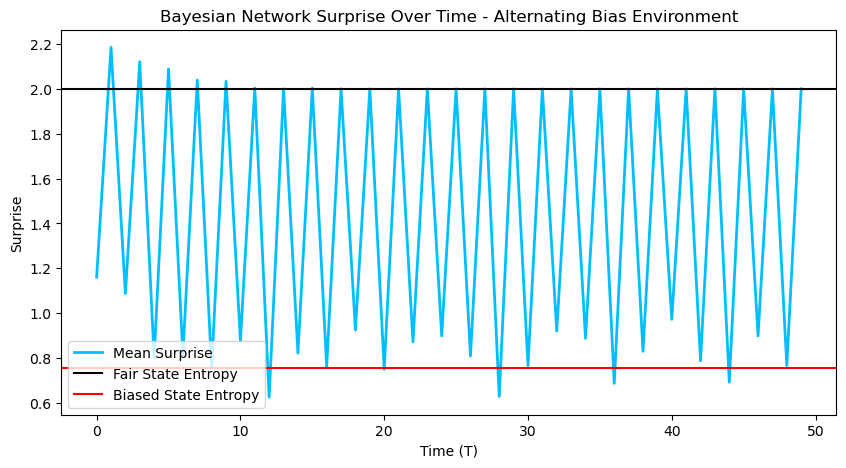

In [ ]:
"""
Plot the mean surprise over time and 10 randomly selected simulations.
"""
T = surprise_data_BN.shape[1]
mean_surprise = np.mean(surprise_data_BN, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_surprise, label='Mean Surprise', linewidth=2, color='deepskyblue')
biased_coin_entropy = -(0.95 * np.log2(0.95) + 0.05 * np.log2(0.05)) - (0.1 * np.log2(0.1) + 0.9 * np.log2(0.9))
plt.axhline(y = 2, label = "Fair State Entropy", linestyle = "solid", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "Biased State Entropy", linestyle = "solid", color = 'red')

plt.xlabel("Time (T)")
plt.ylabel("Surprise")
plt.title("Bayesian Network Surprise Over Time - Alternating Bias Environment")
plt.legend(loc = 3)
plt.show()

<figure>
<figcaption align = "center"> Figure 4: The surprise of a Bayesian Network over a 50 time step simulation in the alternating bias environment. Values quickly converge on the entropies of the biased and fair states, indicating the network has estiblished a strong (and correct) belief about the state of the environment. </figcaption>
</figure>

From the plot above, it can be seen that the average surprise of the network when in both the biased and fair states approaches the true entropy of those states. If we look at the expectations of a sample network over time we can see how this result emerges from the convergence of m_expectation onto the correct representation of the world state.

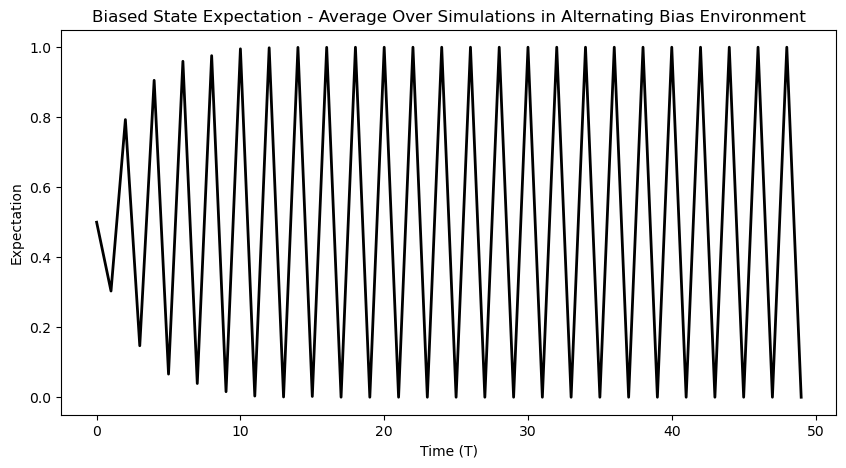

In [ ]:
"""
Plot the mean biased state expectation over time
"""
T = surprise_data_BN.shape[1]
mean_expectation = np.mean(m_expectations_BN[:,:,0], axis = 0) #0 index on 3rd dimension gives the biased state

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_expectation, linewidth=2, color='black')
plt.xlabel("Time (T)")
plt.ylabel("Expectation")
plt.title("Biased State Expectation - Average Over Simulations in Alternating Bias Environment")
plt.show()

<figure>
<figcaption align = "center"> Figure 5: The average (across simulated networks) expectation of the network node representing the biased state for each time step of 50 step simulations. The system is always in the biased state at even time steps, and the expectation weights show that all networks quickly establish correct beliefs about this pattern. </figcaption>
</figure>

Thus, the Bayesian Network successfully performs state estimation via Bayesian Filtering. But what happens when we have no prior model of the environment and attempt to build one using the Bayesian Memory Network? We simulate some networks in the same environment (95%-10% Alternating Bias) using different sensory evidence and continuity priors. Here, we present an illustrative subsample from among a large set of simulations used to explore the dynamics of Bayesian Memory Networks.

In [ ]:
from projective_simulation.bayesianNetworks import Bayesian_Memory

In [ ]:
#Set up Variables
N = 200
T = 200
sensory_evidence_priors = (0.4,0.5,0.7,1,1.5,2)
continuity_priors = (0.5,0.8, 0.9, 0.93, 0.96, 0.98, 0.99)
num_sensory_elements = 2
num_m_nodes = 100
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0


In [ ]:
surprise_data_MN = np.load("example_data/memory_network_simulations1_suprise.npy")
m_expectations_MN = np.load("example_data/memory_network_simulations1_m_expectations.npy")
sensory_expectations_MN = np.load("example_data/memory_network_simulations1_sensory_expectations.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'example_data/memory_network_simulations1_suprise.npy'

Let's look at the surprise over time for a single simulation first to get a sense of the data. In addition to the true entropy for each state, we also plot horizontal lines for the expected surprise of an agent that models the environment using a single state, i.e. it always expects the coins to be heads up in equal proportion to the average rate across both states. Ideally, we want the Bayesian Memory network to make better predictions than this model, indicating that the structure of the network provides and exploits more information that a simple sampling of observations.

In [ ]:
"""
Plot the surprise over time.
"""
T = surprise_data_MN.shape[3]
example_surprise = surprise_data_MN[2,2,0,:] #look at some some intermediate parameters first

plt.figure(figsize=(10, 5))
plt.plot(range(T), example_surprise, linewidth=2, color='deepskyblue')
biased_coin_entropy = -(0.95 * np.log2(0.95) + 0.05 * np.log2(0.05)) - (0.1 * np.log2(0.1) + 0.9 * np.log2(0.9))
one_state_surprise_bias = -(0.95 * np.log2(0.725) + 0.05 * np.log2(0.275)) - (0.1 * np.log2(0.3) + 0.9 * np.log2(0.7))
one_state_surprise_fair = -(0.5 * np.log2(0.725) + 0.5 * np.log2(0.275)) - (0.5 * np.log2(0.3) + 0.5 * np.log2(0.7))
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, label = "one_state_expectation", linestyle = "dashed", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_expectation", linestyle = "dashed", color = 'red')
plt.xlabel("Time (t)")
plt.ylabel("Surprise")
plt.title(r'Bayesian Memory Network Suprise in the 90-10 Alternating Bias Environment ($\kappa = 0.7$, $\delta = 0.9$)')
plt.legend()
plt.show()

<figure>
<figcaption align = "center"> Figure 6: Suprise of a Bayesian Memory Network in a 200 time step simulation of the 95-10 Alternating Bias Environment. As the network accumulates samples of the enviornment by encoding memory traces, it becomes less surprised. Over time, surprise begins to approximate the true entropy of the two environmental states, indicating that information encoded in the overall structure of the memory network reflects the two state structure of the environment. </figcaption>
</figure>

We can see there is some stochasticity in the surprise, which is to be expected: the environment is structured enough that the agent can set non-uniform expectations, but stochastic enough that those expectations will be defied occasionally. Nonetheless, after a period of sampling the network's surprise appears to fluctuate around expected values given the true entropy, or at least the expectations given a single state model of the environment. Now lets look at the same plot, but averaging the surprise over all simulations. To get a better sense of how well the predictions are working, we can plot the average surprise at each time step over all simulations using the same intrinsic priors.

In [ ]:
"""
Plot the mean surprise over time.
"""
T = surprise_data_MN.shape[3]
mean_surprise = np.mean(surprise_data_MN[2,2,:,:], axis=0) #look at some some intermediate parameters first
biased_coin_entropy = -(0.95 * np.log2(0.95) + 0.05 * np.log2(0.05)) - (0.1 * np.log2(0.1) + 0.9 * np.log2(0.9))
one_state_surprise_bias = -(0.95 * np.log2(0.725) + 0.05 * np.log2(0.275)) - (0.1 * np.log2(0.3) + 0.9 * np.log2(0.7))
one_state_surprise_fair = -(0.5 * np.log2(0.725) + 0.5 * np.log2(0.275)) - (0.5 * np.log2(0.3) + 0.5 * np.log2(0.7))

plt.figure(figsize=(10, 5))
plt.plot(range(T), mean_surprise, label='Mean Surprise', linewidth=2, color='deepskyblue')
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, label = "one_state_expectation", linestyle = "dashed", color = 'black')
plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_expectation", linestyle = "dashed", color = 'red')
plt.xlabel("Time (T)")
plt.ylabel("Surprise")
plt.title(r'Average BMN Suprise in the 90-10 Alternating Bias Environment ($\kappa = 0.7$, $\delta = 0.9$)')
plt.legend()
plt.show()

<figure>
<figcaption align = "center"> Figure 7: Average surprise of Bayesian Memory Networks in a 200 time step simulation of the 95-10 Alternating Bias Environment for networks with a sensory evidence prior of 0.7 and a continuity prior of 0.9. The convergence of average surprise between the true entropy of environmental states and the (statistical) expectation given a single state model of the environment indicates that the emergent structure of the Bayesian Memory Graphs relfects the structure of hidden states in the envioronment it is observing. </figcaption>
</figure>

On average, The network surprise falls between the true entropy of the state it is in and the expected surprise given a single state model: exactly what we want. Now that we have a sense of what the data look like over time, we can create some visual summaries of the simulation data when using different intrinsic priors. The following box plot takes the average surprise of each network in the biased and fair states for the latter 100 steps of each simulation (meaning 50 data points for each state for each simulation). The boxes, then, show the spread of these averages over all simulations given a particular set of intrinsic priors.

In [ ]:
from projective_simulation.visualization import simulation_boxplot_summary

In [ ]:
mean_biased_state_surprise = np.mean(surprise_data_MN[:,:,:,[x for x in range(100,T) if x % 2 == 0]], axis = 3)
mean_fair_state_surprise = np.mean(surprise_data_MN[:,:,:,[x for x in range(100,T) if x % 2 == 1]], axis = 3)

plt.figure(figsize=(12, 8))

simulation_boxplot_summary(mean_biased_state_surprise, 
                               param1_values = sensory_evidence_priors, 
                               param2_values = continuity_priors, 
                               title = "Distribution of Mean Surprise Over Simulations",
                               ylabel = "Mean Surprise from t=100 to t=200",
                               parameter_names = ["Sensory Evidence Prior", "Continuity Prior"]
                              )

simulation_boxplot_summary(mean_fair_state_surprise, 
                               param1_values = sensory_evidence_priors, 
                               param2_values = continuity_priors, 
                               title = "Distribution of Mean Surprise Over Simulations",
                               ylabel = "Mean Surprise from t=100 to t=200",
                               parameter_names = ["Sensory Evidence Prior", "Continuity Prior"]
                              )

plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_surprise", linestyle = "dashed", color = 'red')
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, linestyle = "dashed", color = 'black')

plt.show()

<figure>
<figcaption align = "center"> Figure 8: Box plot summaries of average Bayesian Memory Network surprise over the last 100 time steps of simulations in the 95-10 Alternating Bias Environment. Each box represents the average surprises in the biased state (red) and fair state (black) of all simulations given a particular set of intrinsic priors. Solid lines give the true entropy of repective states and dashed line the (statistical) expectation on average suprise for a single state model.  </figcaption>
</figure>

As with previous plots, the red elemets of this plot related to the biased state and the black elements to the fair state. When surprise values fall below the dashed line of the corresponding color, it means the network is making better predictions, on average, than a single state model that makes predictions using the overall rate of heads for each coing. There is a decently wide range of intrinsic priors for which the networks have a predictive advantage over a single state model of the environment, though the advantage is fairly small. Generally, high continuity priors do best until they become very close to one. The best performance appears to be networks with a sensory evidence prior of 0.7 and a continuity prior of 0.96. When the continuity prior is low, the Bayesian Memory Network's predictions approximate those of a single state model of the environment. How can we explain these results? Some further visualizations will help.

First, lets look at how much expectation the networks are putting on traces that were encoded in the same state as the current world state. The following shows the average proportion of expectation on traces encoded following biased flips for the biased states in times steps 100-200.

In [ ]:
total_biased_trace_expectation = np.sum(m_expectations_MN[:,:,:,:,[x for x in range(num_m_nodes) if x % 2 == 0]], axis = 4) #sum over memory traces encoded during biased coin flips
mean_biased_trace_expectation = np.mean(total_biased_trace_expectation[:, :, :,[x for x in range(100,200) if x % 2 == 0]], axis = 3) #average sum of memory trace exictations over all simulations for each parameter set
#Create box plot
plt.figure(figsize=(12, 6))

simulation_boxplot_summary(mean_biased_trace_expectation, 
                               param1_values = sensory_evidence_priors, 
                               param2_values = continuity_priors, 
                               title = "Proportion of Expectation Weight on Traces Encoded During Biased State",
                               ylabel = "Average Proportion over Biased States from t=100 to t=200",
                               parameter_names = ["Sensory Evidence Prior", "Continuity Prior"]
                              )
plt.show()

<figure>
<figcaption align = "center"> Figure 9: Box plot summaries of average proportion of expectation on traces representing biased states when the networks were in biased states.  </figcaption>
</figure>

We can see that the higher the continuity prior, the more the agent expects memory traces from the approprate state to usefully model its current situation. Why does this not always translate to better predictions? The issue is that if the continuity prior is too high, all of the expectation becomes weighted on a small number of traces, leading the network to become overconfident that the sensory state will reflect the small sample of memories being used to make predictions. Let's look at an example. Each row of the following plots shows the weight of excitation on the memory traces of a network with continuity prior of 0.99 and a sensory evidence prior of 0.7. Each row is a time step in the simulation.

In [ ]:
from projective_simulation.visualization import plot_heatmap

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

plot_heatmap(m_expectations_MN[2,6,0,0:100,:], ax = axes[0])
plot_heatmap(m_expectations_MN[2,6,0,100:200,:], extent = [0,100,200,100], ax = axes[1])
plt.show()

<figure>
<figcaption align = "center"> Figure 10: Expectation weights of memory traces in an example Bayesian Memory Network with sensory evidence prior = 0.7 and continuity prior = 0.99 during simulation in the 95-10 Alternating Bias Environment. Initially, expectation is fully loaded on the first (and only) encoded memory trace. Over the first 100 times steps (left), expectation slowly diffuses to more recently encoded traces that usefully represent the environment. However, even after two hundred time steps (right) expectation is only loaded onto a small subset of the traces that could usefully represent the environment state.  </figcaption>
</figure>

What we can see is that in the second time step, all of the expectation is on the first trace (it is the network's only memory). Because the continuity prior is high, this expectation is propogated strongly forward - but the expectation is wrong! In the second time step, the system is in the fair state, but the first memory trace represents a time step when the system was in the biased state. Over time, it can be seen that sensory evidence slowly accumulates and expectation shifts to other traces - those representing the correct system state. Even after 200 time steps, however, most of the expectation remains on only a few traces. The result is that the expectation of sensory elements depends largely on the sequence of sensory states the agent observed subsequent to those traces. 

The following plots shows the expectation on the sensory elements over the last 50 biased states (i.e. the probability with which the network expects to see the quarter and the nickel come up heads) and the last 50 fair states.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

plot_heatmap(sensory_expectations_MN[2,6,0,[x for x in range(100,200) if x % 2 ==0],:], 
             ylabel = "Biased State Occurace (post time step 100)", 
             title = "Expectation of Sensory Elements (Biased State)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5],
             xtick_labels = [0,1],
             ax = axes[0])

plot_heatmap(sensory_expectations_MN[2,6,0,[x for x in range(100,200) if x % 2 ==1],:], 
             ylabel = "Fair State Occurace (post time step 100)", 
             title = "Expectation of Sensory Elements (Fair State)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5],
             xtick_labels = [0,1],
             ax = axes[1])

plt.show()

<figure>
<figcaption align = "center"> Figure 11: Expectation weights of sensory elements in an example Bayesian Memory Network with sensory evidence prior = 0.7 and continuity prior = 0.99 during simulation in the 95-10 Alternating Bias Environment.  </figcaption>
</figure>

We can see a lot of variance in the expectations - while the expectations may, on average, reflect the true proabilities of seeing heads in those states, the step-by-step expectations are generally over-confident. On the other hand, here are the same plots for a network with the same sensory evidence prior but a continuity prior of 0.93.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)

plot_heatmap(m_expectations_MN[2,3,0,0:100,:], ax = axes[0,0])
plot_heatmap(m_expectations_MN[2,3,0,100:200,:], extent = [0,100,200,100], ax = axes[0,1])
plot_heatmap(sensory_expectations_MN[2,3,0,[x for x in range(100,200) if x % 2 ==0],:], 
             ylabel = "Biased State Occurace (post time step 100)", 
             title = "Expectation of Sensory Elements (Biased State)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5],
             xtick_labels = [0,1],
             ax = axes[1,0])
plot_heatmap(sensory_expectations_MN[2,3,0,[x for x in range(100,200) if x % 2 ==1],:], 
             ylabel = "Fair State Occurace (post time step 100)", 
             title = "Expectation of Sensory Elements (Fair State)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5],
             xtick_labels = [0,1],
             ax = axes[1,1])

plt.show()

<figure>
<figcaption align = "center"> Figure 11: Expectation weights in an example Bayesian Memory Network with sensory evidence prior = 0.7 and continuity prior = 0.9 during simulation in the 95-10 Alternating Bias Environment.  </figcaption>
</figure>

Notice the alternating pattern in the expectation of memory traces. The expectation has become more evenly distributed over memory traces that represent the current state. Resultingly, expectation on the sensory elements closely matches the true probility in each time step.

We can see that the network improves its ability to make predictions as it gather sensory samples from them environment and encodes them to its episodic memory. It also is able to make 

One thing we might conclude is that the strength of the sensory evidence prior ought to be proportional to the effective entropy of the sensory elements and the strength of continuity ought to be proportional to the entropy of the system states. However, what is most important is that the priors balance pushing expectectation toward the most representative traces while allowing it to remain distributed enough to activate a representative sample of possible scenarios. To further our intuition for this trade-off, lets look at some simulations in an environment where the biased state has a higher entropy.

In [ ]:
#Set up Variables
N = 200
T = 200
sensory_evidence_priors = (0.4,0.5,0.7,1,1.5,2)
continuity_priors = (0.5,0.8, 0.9, 0.93, 0.96, 0.98, 0.99)
num_sensory_elements = 2
num_m_nodes = 100
probabilities = np.array(([0.8,0.5],[0.3,0.5]))
transitions = np.array(([0,1],[1,0]))
env_state = 0

In [ ]:
surprise_data_MN2 = np.load("example_data/memory_network_simulations2_suprise.npy")
m_expectations_MN2 = np.load("example_data/memory_network_simulations2_m_expectations.npy")
sensory_expectations_MN2 = np.load("example_data/memory_network_simulations2_sensory_expectations.npy")

In [ ]:
mean_biased_state_surprise = np.mean(surprise_data_MN2[:,:,:,[x for x in range(100,T) if x % 2 == 0]], axis = 3)
mean_fair_state_surprise = np.mean(surprise_data_MN2[:,:,:,[x for x in range(100,T) if x % 2 == 1]], axis = 3)

biased_coin_entropy = -(0.8 * np.log2(0.8) + 0.2 * np.log2(0.2)) - (0.3 * np.log2(0.3) + 0.7 * np.log2(0.7))
one_state_surprise_bias = -(0.8 * np.log2(0.65) + 0.2 * np.log2(0.35)) - (0.3 * np.log2(0.4) + 0.7 * np.log2(0.6))
one_state_surprise_fair = -(0.5 * np.log2(0.65) + 0.5 * np.log2(0.35)) - (0.5 * np.log2(0.4) + 0.5 * np.log2(0.6))

# Create box plot
plt.figure(figsize=(12, 8))

simulation_boxplot_summary(mean_biased_state_surprise, 
                               param1_values = sensory_evidence_priors, 
                               param2_values = continuity_priors, 
                               title = "Distribution of Mean Surprise Over Simulations",
                               ylabel = "Mean Surprise from t=100 to t=200",
                               parameter_names = ["Sensory Evidence Prior", "Continuity Prior"]
                              )

simulation_boxplot_summary(mean_fair_state_surprise, 
                               param1_values = sensory_evidence_priors, 
                               param2_values = continuity_priors, 
                               title = "Distribution of Mean Surprise Over Simulations",
                               ylabel = "Mean Surprise from t=100 to t=200",
                               parameter_names = ["Sensory Evidence Prior", "Continuity Prior"]
                              )

plt.axhline(y = biased_coin_entropy, label = "biased coin entropy", linestyle = "solid", color = 'red')
plt.axhline(y = one_state_surprise_bias, label = "one_state_surprise", linestyle = "dashed", color = 'red')
plt.axhline(y = 2, label = "fair coin entropy", linestyle = "solid", color = 'black')
plt.axhline(y = one_state_surprise_fair, linestyle = "dashed", color = 'black')

plt.show()

<figure>
<figcaption align = "center"> Figure 12: Box plot summaries of average Bayesian Memory Network surprise over the last 100 time steps of simulations in the 80-30 Alternating Bias Environment. Each box represents the average surprises in the biased state (red) and fair state (black) of all simulations given a particular set of intrinsic priors. Solid lines give the true entropy of respective states and dashed line the (statistical) expectation on average suprise for a single state model.  </figcaption>
</figure>

What we can see is that indeed the best sensory evidence prior is now a bit lower. The ability of the network to extract information about the hidden states of the environment is also smaller, and limited to a smaller range of parameter values. None-the-less, an advangtage can be obtained, despite the very limited information available to the networks in this environment. Eventually, we will aim to understand how deliberative processes on the Bayesian Memory Network can help it learn about relevant associations between memories and thus structurally encode information about hidden properties of the environment. First, however, we need to introduce how the Bayesian Memory Network can be used the guide the actions of an agent.

## The Active Inference Memory Network

The Active Inference framework holds that biological agents maintain their embodied state in the world by minimizing the free energy of their embodied systems. Surprise is one component of the system's free energy; minimizing surprise contributes toward minimizing free energy. If we allow that some of the sensory elements of a Bayesian Memory Network correspond to the actions of an agent (we will call these *active sensory elements*), that the surprise of the BMN at any given time becomes encoded into the appropriate memory trace, and that these encoded surprise values mediate the expectation feedback to action elements, then it becomes possible for the agent to use the expectation of action elements as a signal of future surprise if that action is taken. 

To implement these changes, we first need to define an action encoding vector, $\boldsymbol{A^*}$, where each element $A^*_\mathrm{i}$ takes the value 1 if $S_i$ represents an active sensory element and takes the value 0 otherwise. Second, we need to define a vector of memory trace valences, $\boldsymbol{V}$, such that $V_\mathrm{j_last}^{(t)} \leftarrow I(\boldsymbol{s^{(t)})}$ where $\mathrm{j_last} = (t \ \mathrm{mod} \  \lvert M \rvert) - 1$, i.e. the index of the last memory trace encoded. Finally, we must update equation 6, which defines how expectation is passed to sensory elements, to

\begin{equation}
\hat{S}_\mathrm{i} =
\left\{
\begin{array}{ll}
  f_\epsilon(\sum_{\mathrm{j} = 1}^{\lvert M \rvert} \hat{M}_\mathrm{j}W_\mathrm{ij}),  & \text{if } A^*_\mathrm{i} = 0  \\
  \sum_{\mathrm{j} =1}^{\lvert M \rvert} \hat{M}_\mathrm{j} W_\mathrm{ij} log(\frac{\bar{\boldsymbol{V}}}{V_j}) & \text{otherwise},
\end{array}
\right.
\end{equation}

where $log(\frac{\bar{\boldsymbol{V}}}{V_j})$ give the *surprise advantage* of memory trace $\mathrm{j}$ relative to the average surprise encoded in memory trace valences.

Finally, because the expectation of active sensory elements no longer gives a probability, and we do not want the agent to be surprised by its own actions, we exclude these sensory elements from the surprise computation.

We have thus defined a Bayesian Memory Network that encodes certain sensory elements as action representations. The expectation that is passed to these action representations is mediated by the valences of memory traces and is scaled differently than other sensory elements. We will call this modified Bayesian Memory Network the Active Inference Network. An agent can now select its next action based on the sensory expectation of an Active Inference Network using the following probability density function:

\begin{equation}
Pr(A = a^{(\mathrm{j})}|\hat{\boldsymbol{S}}) = \frac{\mathrm{e}^{A^*_\mathrm{j} \hat{S}_\mathrm{j}}}{\sum_\mathrm{j'=1}^{\lvert \boldsymbol{S} \rvert}\mathrm{e}^{A^*_\mathrm{j'} \hat{S}_\mathrm{j'}}}
\end{equation}

Let us demonstrate. We will run a set of simulations in the baised coin environment, but instead of alternating between the fair and biased states, the agents action will determine whether the next flip is fair or biased: Action "0" means the next flip will be biased and Action "1" means the next flip will be fair. We will call this the controlled flip environment.

In [ ]:
from projective_simulation.bayesianNetworks import Active_Inference_Memory, Basic_Agent, Controlled_Flip_Generator

In [ ]:
#Set up Variables
N = 200
T = 200
num_m_nodes = 100
sensory_evidence_priors = (0.2,0.4,0.7,1)
continuity_priors = (0.5,0.7, 0.9, 0.98)
action_softmax_temps = (1,2,3,4)
num_flip_states = 2
num_coins = 2
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array([[[1,0],[1,0]],[[0,1],[0,1]]])
env_state = 0

In [ ]:
surprise_data_AI1 = np.load("example_data/AI_network_simulations1_suprise.npy")
m_expectations_AI1 = np.load("example_data/AI_network_simulations1_m_expectations.npy")
sensory_expectations_AI1 = np.load("example_data/AI_network_simulations1_sensory_expectations.npy")
action_data_AI1 = np.load("example_data/AI_network_simulations1_actions.npy")

In [ ]:
mean_action0 = np.mean(action_data_AI1[:,:,:,:,range(100,T)], axis = 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

for i in range(np.shape(mean_action0)[2]):
    ax = axes[i//2,i%2]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_action0[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Action 1 Proportion",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )

plt.show()

In [ ]:
#Set up Variables
N = 200
T = 200
num_m_nodes = 50
sensory_evidence_priors = (0.1,0.2,0.3)
continuity_priors = (0.8, 0.9, 0.98)
action_softmax_temps = (3,4,5)
num_flip_states = 2
num_coins = 2
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array([[[1,0],[1,0]],[[0,1],[0,1]]])
env_state = 0

In [ ]:
surprise_data_AI2 = np.load("example_data/AI_network_simulations2_suprise.npy")
m_expectations_AI2 = np.load("example_data/AI_network_simulations2_m_expectations.npy")
sensory_expectations_AI2 = np.load("example_data/AI_network_simulations2_sensory_expectations.npy")
action_data_AI2 = np.load("example_data/AI_network_simulations2_actions.npy")

In [ ]:
mean_action0 = np.mean(action_data_AI2[:,:,:,:,range(100,T)], axis = 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

for i in range(np.shape(mean_action0)[2]):
    ax = axes[i//2,i%2]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_action0[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Action 1 Proportion",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )

plt.show()

In [ ]:
#Set up Variables
N = 200
T = 300
num_m_nodes = 100
sensory_evidence_priors = (0.05,0.1,0.2)
continuity_priors = (0.8, 0.9)
action_softmax_temps = (4,5)
num_flip_states = 2
num_coins = 2
probabilities = np.array(([0.95,0.5],[0.1,0.5]))
transitions = np.array([[[1,0],[1,0]],[[0,1],[0,1]]])
env_state = 0

In [ ]:
surprise_data_AI3 = np.load("example_data/AI_network_simulations3_suprise.npy")
m_expectations_AI3 = np.load("example_data/AI_network_simulations3_m_expectations.npy")
sensory_expectations_AI3 = np.load("example_data/AI_network_simulations3_sensory_expectations.npy")
action_data_AI3 = np.load("example_data/AI_network_simulations3_actions.npy")

In [ ]:
mean_action0 = np.mean(action_data_AI3[:,:,:,:,range(100,T)], axis = 4)

fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

for i in range(np.shape(mean_action0)[2]):
    ax = axes[i]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_action0[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Action 1 Proportion",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )

plt.show()

TO BE CONTINUED (i.e. will start introducing and explaining the code below)

In [ ]:
class Match2Sample():
    def __init__(self,
                 choices: int, 
                 delay: int = 0,
                 penalty: int = 0,
                 max_trial_time: int = 5):
        self.choices = choices
        self.penalty = penalty
        self.delay = delay
        self.timeout = 0
        self.trial_time = 0
        self.state = [0, 1 + np.random.randint(self.choices)] #gives reward and stimulus state. Stimulus 0 reserved for delay and reward states

    def get_observation(self):
        if self.trial_time <= 1:
            return self.state
        else:
            return [0,0] #hide stimulus in delay condition

    def transition(self, action):
        if self.timeout > 0:  #in timeout, reduce by 1
            self.state = [0,self.choices + 1]  #no reward, stimulus indicates timeout/new trial
            self.timeout -= 1
        
        elif self.state[1] == self.choices + 1: #in intialization or reward, start new trial by presenting new stimulus
            self.state = [0,1 + np.random.randint(self.choices)] #gives reward and stimulus state. Stimulus 0 reserved for delay and reward states

        elif self.trial_time <= self.delay: #initial presentation of stimulus. Continue presentation regardless of action
            self.trial_time += 1
            
        elif action == self.state[1]: #trial success
            self.state = [1,self.choices + 1] #give reward, stimulus indicates timeout/new trial
            self.trial_time = 0

        else: #trial failure
            self.state = [0,self.choices + 1] #no reward, stimulus indicates timeout/new trial
            self.timeout = self.penalty
            self.trial_time = 0

In [ ]:
choices = 2
num_m_nodes = 100
reward_strength = 3
test_m2s = Match2Sample(choices)
test_memory = Active_Inference_Memory(num_sensory_elements = choices + 2, #1 element for each choice stimulus, one for timeout, and one for reward
                                      intrinsic_expectations = np.append(np.full(1, fill_value = reward_strength), np.zeros(choices + 1)),
                                     num_action_elements = choices,
                                     sensory_evidence_prior = 5, 
                                     continuity_prior = 0.95,
                                      epsilon = 0.001,
                                     num_m_nodes = num_m_nodes)
test_agent = Basic_Agent(test_memory, action_softmax_temp = 2)

T = 200

sensory_expectation_data = [None] * T
action_data = [None] * T
state_data = [None] * T
t = 0


In [ ]:
env_state = test_m2s.get_observation()
print(env_state)
print(test_memory.sensory_expectation)
action = test_agent.get_action()
print(action)

[1, 3]
[0.70891733 0.99740295 0.00206047 0.00153459 0.00103266 0.        ]
0


In [ ]:
choice_observation = [1 if env_state[1] == x + 1 else 0 for x in range(choices + 1)]
observation = np.append(env_state[0], choice_observation)
print(observation)
test_agent.deliberate(observation)
print(test_memory.W_matrix)
test_m2s.transition(action)


[1 0 0 1]
[[0.  0.  0.  0.  0.  1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.  0.  0.  1.  1.  0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [1.  1.  0.  0.  0.  0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.

In [ ]:
print(test_memory.m_activation)

[5.31349628e-04 9.99468650e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [ ]:
#Set up Variables
N = 200
T = 300
num_m_nodes = 100
choices = 2
delay = 0
reward_strength = 4
sensory_evidence_priors = (0.5,1,3,5)
continuity_priors = (0.5, 0.7, 0.8, 0.9)
action_softmax_temps = (2,3,4,5)

In [ ]:
"""
Run N simulations for T iterations, storing the surprise values and m_expectations.
"""
surprise_data_M2S_1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps), N, T))
m_expectations_M2S_1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,num_m_nodes))
sensory_expectations_M2S_1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2 * choices + 2)) #1 element for each choice stimulus, one for timeout, and one for reward
action_data_M2S_1 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T))
observation_data_M2S_1 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2))

for i in range(len(sensory_evidence_priors)):
    for j in range(len(continuity_priors)):
        for k in range(len(action_softmax_temps)):
            for n in range(N):
                env = Match2Sample(choices, delay = delay)
                memory = Active_Inference_Memory(num_sensory_elements = choices + 2, #1 element for each choice stimulus, one for timeout, and one for reward
                                                 intrinsic_expectations = np.append(np.full(1, fill_value = reward_strength), np.zeros(choices + 1)),
                                                 num_action_elements = choices,
                                                 sensory_evidence_prior = sensory_evidence_priors[i], 
                                                 continuity_prior = continuity_priors[j],
                                                 epsilon = 0.001,
                                                 num_m_nodes = num_m_nodes)
                agent = Basic_Agent(memory, action_softmax_temp = action_softmax_temps[k])
                
                t = 0
                while t < T:
                    raw_observation = env.get_observation()
                    observation_data_M2S_1[i,j,k,n,t,:] = raw_observation
                    m_expectations_M2S_1[i,j,k,n,t,:] = memory.m_expectation
                    sensory_expectations_M2S_1[i,j,k,n,t,:] = memory.sensory_expectation
                    action = agent.get_action()
                    action_data_M2S_1[i,j,k,n,t] = action
                    choice_observation = [1 if raw_observation[1] == x + 1 else 0 for x in range(choices + 1)] #choices plus timeout indicator
                    observation = np.append(raw_observation[0], choice_observation)
                    agent.deliberate(observation)
                    env.transition(action + 1) #translate from action inded for agent to action label for env
                    t += 1
np.save("example_data/M2S_sim1_suprise.npy", surprise_data_M2S_1)
np.save("example_data/M2S_sim1_m_expectations.npy", m_expectations_M2S_1)
np.save("example_data/M2S_sim1_sensory_expectations.npy", sensory_expectations_M2S_1)
np.save("example_data/M2S_sim1_actions.npy", action_data_M2S_1)
np.save("example_data/M2S_sim1_observations.npy", observation_data_M2S_1)

In [ ]:
surprise_data_M2S_1 = np.load("example_data/M2S_sim1_suprise.npy")
m_expectations_M2S_1 = np.load("example_data/M2S_sim1_m_expectations.npy")
sensory_expectations_M2S_1 = np.load("example_data/M2S_sim1_sensory_expectations.npy")
action_data_M2S_1 = np.load("example_data/M2S_sim1_actions.npy")
observation_data_M2S_1 = np.load("example_data/M2S_sim1_observations.npy")

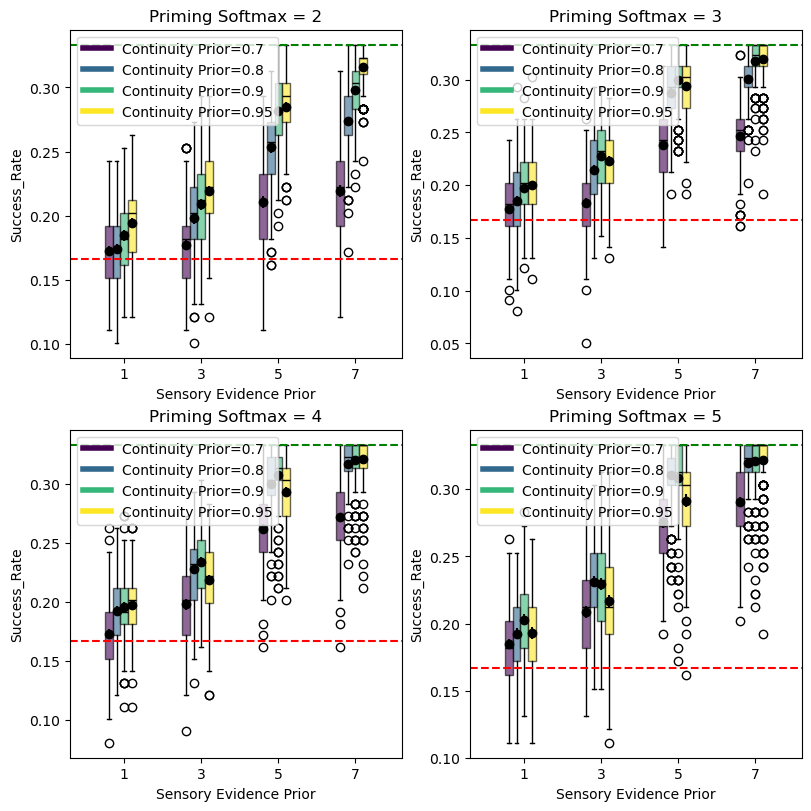

In [ ]:
mean_success = np.mean(observation_data_M2S_1[:,:,:,:,range(201,T),0], axis = 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

for i in range(np.shape(mean_success)[2]):
    ax = axes[i//2,i%2]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_success[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Success_Rate",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )
    plt.axhline(y = 1/3, label = "Optimal", linestyle = "dashed", color = 'green')
    plt.axhline(y = 1/6, label = "Random Choce", linestyle = "dashed", color = 'red')

plt.show()

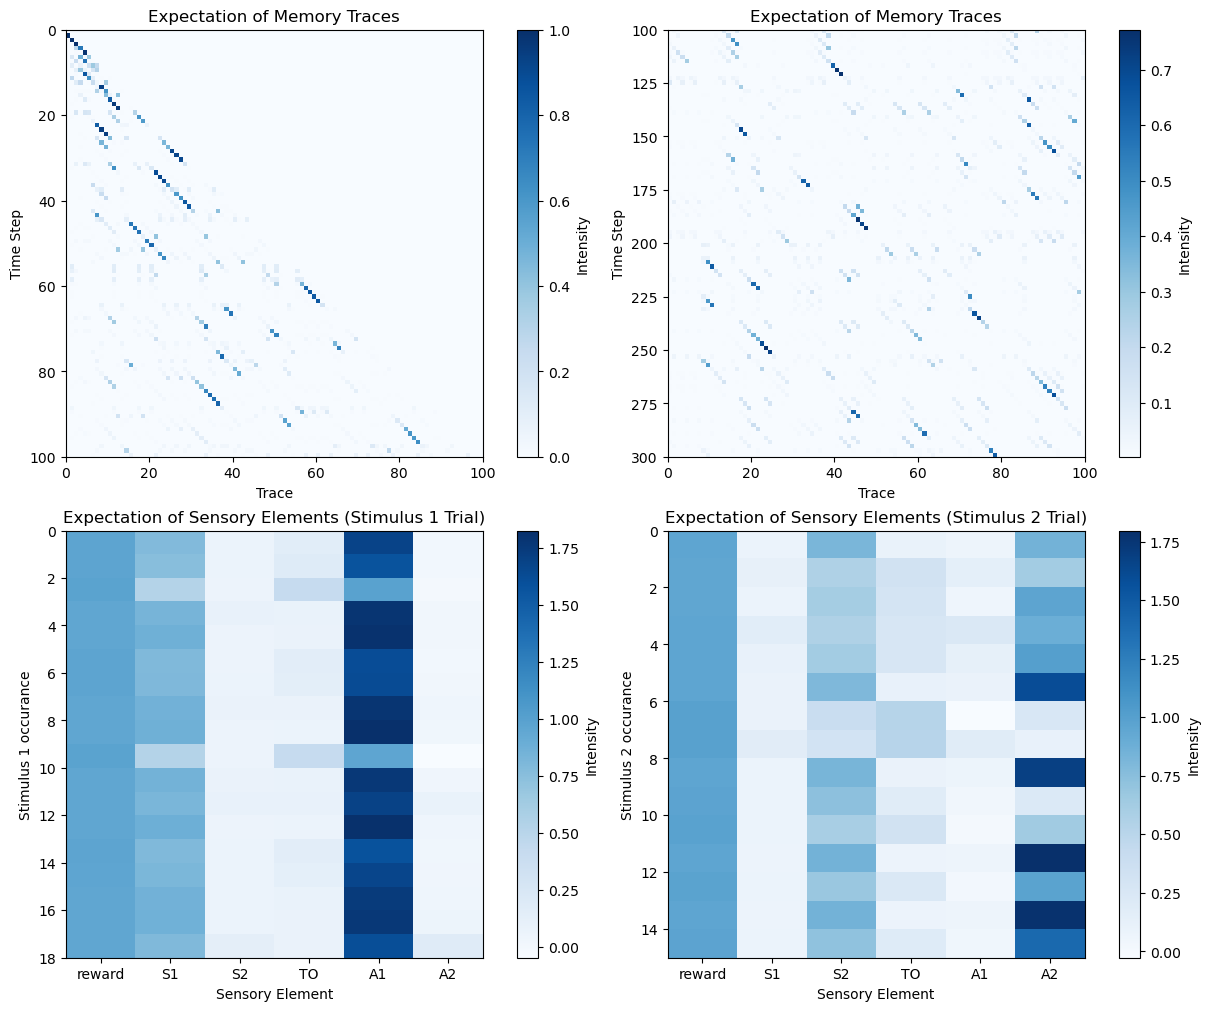

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)

plot_heatmap(m_expectations_M2S_1[3,2,2,0,0:100,:], ax = axes[0,0])
plot_heatmap(m_expectations_M2S_1[3,2,2,0,200:300,:], extent = [0,100,300,100], ax = axes[0,1])
plot_heatmap(sensory_expectations_M2S_1[3,2,2,0,[t for t in range(200,300) if t % 3 == 1 and observation_data_M2S_1[3,2,2,0,t,1] == 1],:], 
             ylabel = "Stimulus 1 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 1 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,0])
plot_heatmap(sensory_expectations_M2S_1[3,2,2,0,[t for t in range(200,300) if t % 3 == 1 and observation_data_M2S_1[3,2,2,0,t,1] == 2],:], 
             ylabel = "Stimulus 2 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 2 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,1])

plt.show()

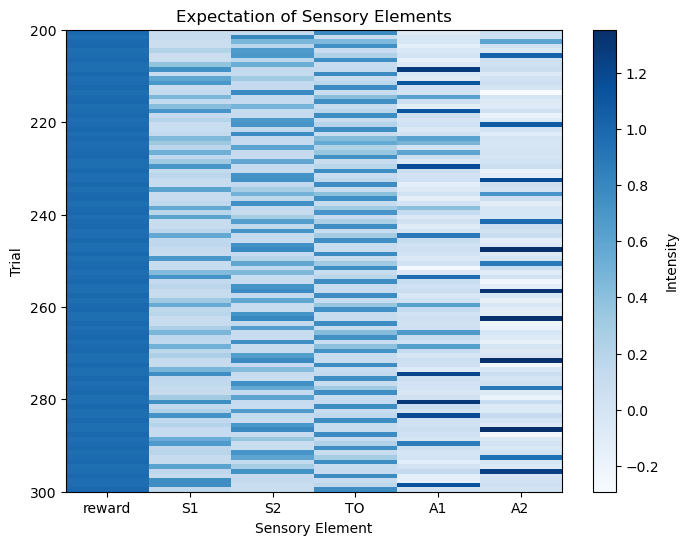

In [ ]:
plot_heatmap(sensory_expectations_M2S_1[3,1,2,1,range(200,300),:],
             extent = [0,6,300,200],
             ylabel = "Trial", 
             title = "Expectation of Sensory Elements", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"])

### Delayed Response
#### Delay 1

In [ ]:
choices = 2
num_m_nodes = 100
reward_strength = 3
test_DR1 = Match2Sample(choices, delay = 1)
test_memory = Active_Inference_Memory(num_sensory_elements = choices + 2, #1 element for each choice stimulus, one for timeout, and one for reward
                                      intrinsic_expectations = np.append(np.full(1, fill_value = reward_strength), np.zeros(choices + 1)),
                                     num_action_elements = choices,
                                     sensory_evidence_prior = 5, 
                                     continuity_prior = 0.95,
                                      epsilon = 0.001,
                                     num_m_nodes = num_m_nodes)
test_agent = Basic_Agent(test_memory, action_softmax_temp = 2)

In [ ]:
env_state = test_DR1.get_observation()
print(env_state)
print(test_memory.sensory_expectation)
action = test_agent.get_action()
print(action)

[1, 3]
[ 7.08917331e-01  2.58746305e-03  9.98003992e-04  9.98003992e-04
 -1.11285945e-04  0.00000000e+00]
0


In [ ]:
choice_observation = [1 if env_state[1] == x + 1 else 0 for x in range(choices + 1)]
observation = np.append(env_state[0], choice_observation)
print(observation)
test_agent.deliberate(observation)
print(test_memory.W_matrix)
test_DR1.transition(action)

[1 0 0 1]
[[0.  0.  0.  1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [1.  1.  0.  0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.

In [ ]:
print(test_memory.m_expectation)

[5.29661017e-04 1.05435234e-03 1.10869798e-03 8.75918369e-03
 9.79363664e-01 1.10274212e-03 5.85817510e-04 7.49588122e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [ ]:
#Set up Variables
N = 200
T = 300
num_m_nodes = 100
choices = 2
delay = 1
reward_strength = 4
sensory_evidence_priors = (1,3,5,7)
continuity_priors = (0.7, 0.8, 0.9, 0.95)
action_softmax_temps = (2,3,4,5)

In [ ]:
"""
Run N simulations for T iterations, storing the surprise values and m_expectations.
"""
surprise_data_DR1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps), N, T))
m_expectations_DR1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,num_m_nodes))
sensory_expectations_DR1 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2 * choices + 2)) #2 elements for each choice stimulus (sensory and action), one for timeout, and one for reward
action_data_DR1 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T))
observation_data_DR1 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2))

for i in range(len(sensory_evidence_priors)):
    for j in range(len(continuity_priors)):
        for k in range(len(action_softmax_temps)):
            for n in range(N):
                env = Match2Sample(choices, delay = delay)
                memory = Active_Inference_Memory(num_sensory_elements = choices + 2, #1 element for each choice stimulus, one for timeout, and one for reward
                                                 intrinsic_expectations = np.append(np.full(1, fill_value = reward_strength), np.zeros(choices +1)), #intrinisc expectation of 1 for reward, 0 for each choice stimulus, including timeout
                                                 num_action_elements = choices,
                                                 sensory_evidence_prior = sensory_evidence_priors[i], 
                                                 continuity_prior = continuity_priors[j],
                                                 epsilon = 0.001,
                                                 num_m_nodes = num_m_nodes)
                agent = Basic_Agent(memory, action_softmax_temp = action_softmax_temps[k])
                
                t = 0
                while t < T:
                    raw_observation = env.get_observation()
                    observation_data_DR1[i,j,k,n,t,:] = raw_observation
                    m_expectations_DR1[i,j,k,n,t,:] = memory.m_expectation
                    sensory_expectations_DR1[i,j,k,n,t,:] = memory.sensory_expectation
                    action = agent.get_action()
                    action_data_DR1[i,j,k,n,t] = action
                    choice_observation = [1 if raw_observation[1] == x + 1 else 0 for x in range(choices + 1)] #choice stimuli plus timeout stimulus
                    observation = np.append(raw_observation[0], choice_observation)
                    agent.deliberate(observation)
                    env.transition(action + 1) #translate from action inded for agent to action label for env
                    t += 1
np.save("example_data/DR1_suprise.npy", surprise_data_DR1)
np.save("example_data/DR1_m_expectations.npy", m_expectations_DR1)
np.save("example_data/DR1_sensory_expectations.npy", sensory_expectations_DR1)
np.save("example_data/DR1_actions.npy", action_data_DR1)
np.save("example_data/DR1_observations.npy", observation_data_DR1)

In [ ]:
surprise_data_DR1 = np.load("example_data/DR1_suprise.npy")
m_expectations_DR1 = np.load("example_data/DR1_m_expectations.npy")
sensory_expectations_DR1 = np.load("example_data/DR1_sensory_expectations.npy")
action_data_DR1 = np.load("example_data/DR1_actions.npy")
observation_data_DR1 = np.load("example_data/DR1_observations.npy")

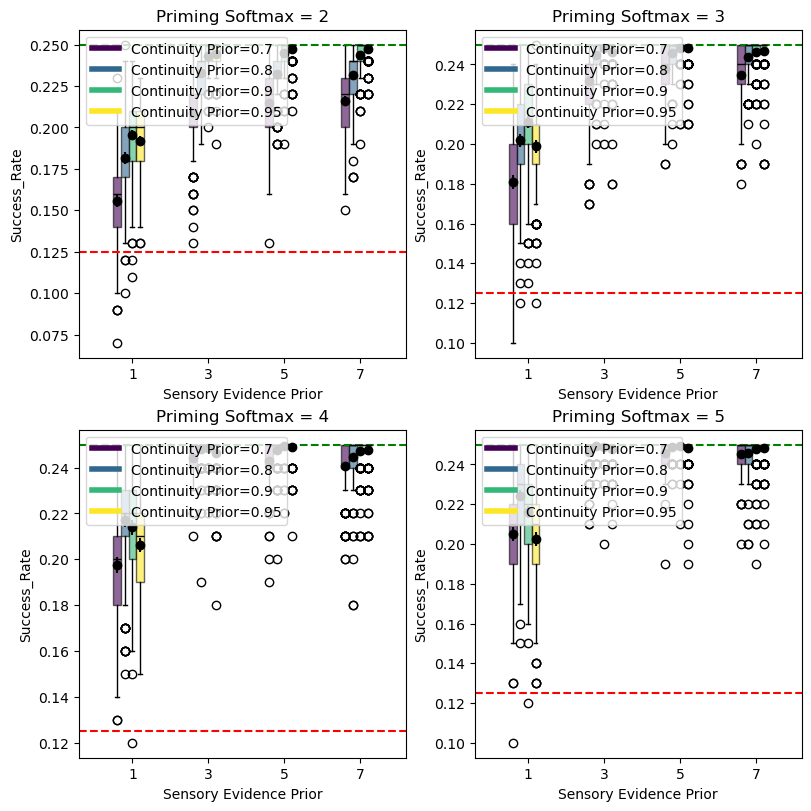

In [ ]:
mean_success = np.mean(observation_data_DR1[:,:,:,:,range(200,T),0], axis = 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

for i in range(np.shape(mean_success)[2]):
    ax = axes[i//2,i%2]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_success[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Success_Rate",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )
    plt.axhline(y = 1/4, label = "Optimal", linestyle = "dashed", color = 'green')
    plt.axhline(y = 1/8, label = "Random Choce", linestyle = "dashed", color = 'red')

plt.show()

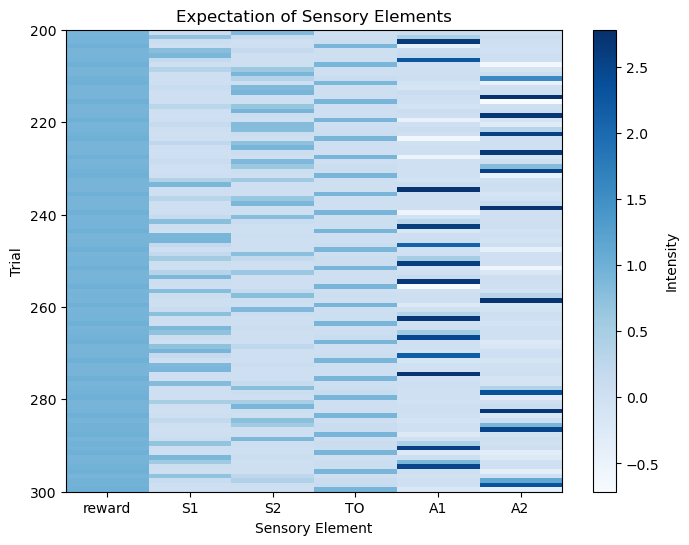

In [ ]:
plot_heatmap(sensory_expectations_DR1[2,2,3,0,range(200,300),:],
             extent = [0,6,300,200],
             ylabel = "Trial", 
             title = "Expectation of Sensory Elements", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"])

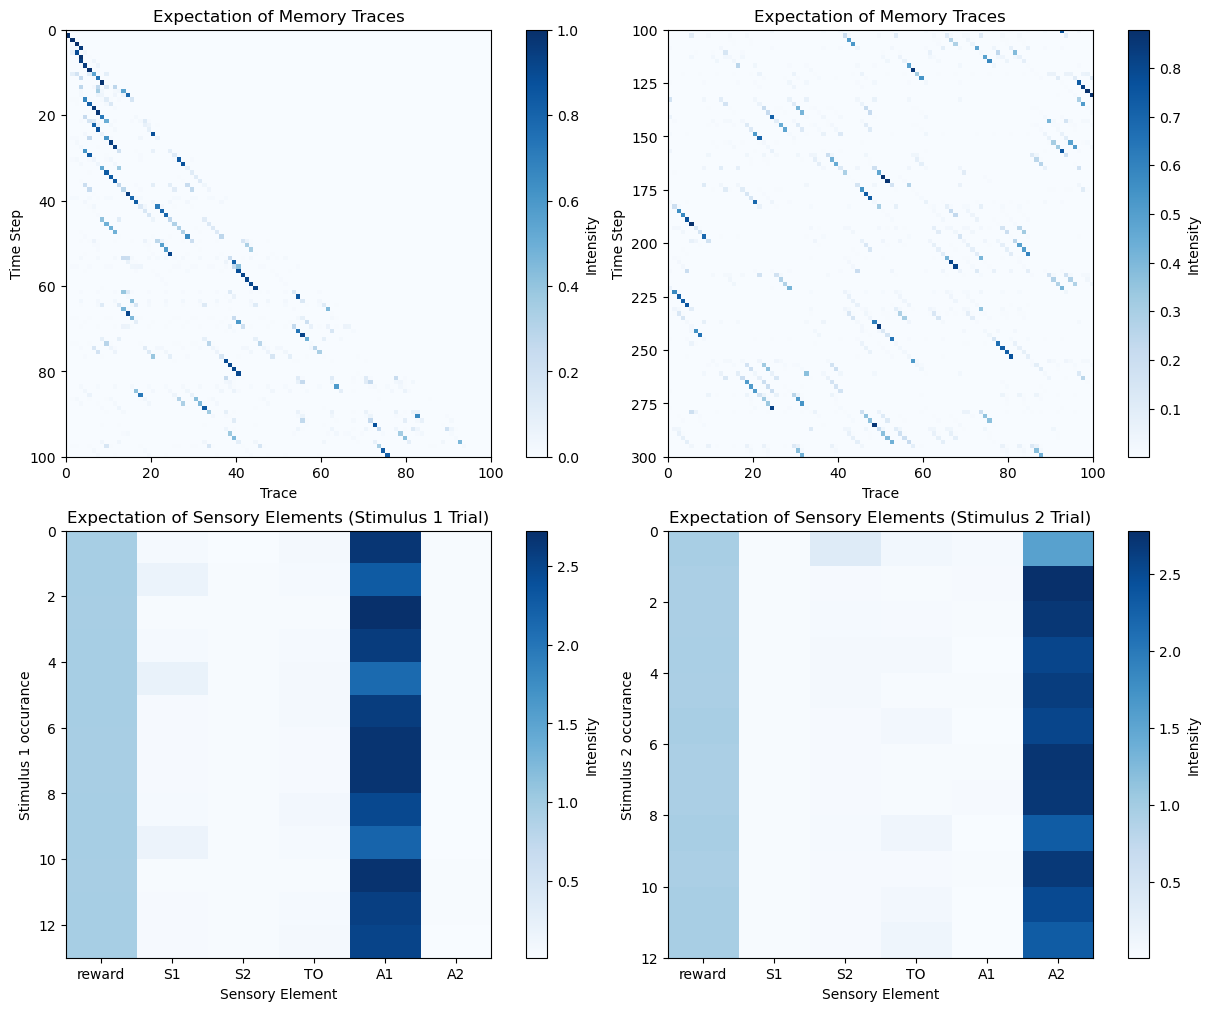

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)

plot_heatmap(m_expectations_DR1[2,2,3,0,0:100,:], ax = axes[0,0])
plot_heatmap(m_expectations_DR1[2,2,3,0,200:300,:], extent = [0,100,300,100], ax = axes[0,1])
plot_heatmap(sensory_expectations_DR1[2,2,3,0,[t for t in range(200,300) if t % 4 == 2 and observation_data_DR1[2,2,3,0,t-1,1] == 1],:], #get test step, check previous timestep for stimulus
             ylabel = "Stimulus 1 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 1 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,0])
plot_heatmap(sensory_expectations_DR1[2,2,3,0,[t for t in range(200,300) if t % 4 == 2 and observation_data_DR1[2,2,3,0,t-1,1] == 2],:], 
             ylabel = "Stimulus 2 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 2 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,1])

plt.show()

#### Delay 3

In [ ]:
#Set up Variables
N = 200
T = 300
num_m_nodes = 100
choices = 2
delay = 3
reward_strength = 4
sensory_evidence_priors = (1,3,5,7)
continuity_priors = (0.7, 0.8, 0.9, 0.95)
action_softmax_temps = (2,3,4,5)

In [ ]:
"""
Run N simulations for T iterations, storing the surprise values and m_expectations.
"""
surprise_data_DR3 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps), N, T))
m_expectations_DR3 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,num_m_nodes))
sensory_expectations_DR3 = np.zeros((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2 * choices + 2)) #2 elements for each choice stimulus (sensory and action), one for timeout, and one for reward
action_data_DR3 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T))
observation_data_DR3 = np.empty((len(sensory_evidence_priors), len(continuity_priors),len(action_softmax_temps),N,T,2))

for i in range(len(sensory_evidence_priors)):
    for j in range(len(continuity_priors)):
        for k in range(len(action_softmax_temps)):
            for n in range(N):
                env = Match2Sample(choices, delay = delay)
                memory = Active_Inference_Memory(num_sensory_elements = choices + 2,  #1 element for each choice stimulus, one for timeout, and one for reward
                                                 intrinsic_expectations = np.append(np.full(1, fill_value = reward_strength), np.zeros(choices + 1)), #intrinisc expectation of 1 for reward, 0 for each choice stimulus, including timeout
                                                 num_action_elements = choices,
                                                 sensory_evidence_prior = sensory_evidence_priors[i], 
                                                 continuity_prior = continuity_priors[j],
                                                 epsilon = 0.001,
                                                 num_m_nodes = num_m_nodes)
                agent = Basic_Agent(memory, action_softmax_temp = action_softmax_temps[k])
                
                t = 0
                while t < T:
                    raw_observation = env.get_observation()
                    observation_data_DR3[i,j,k,n,t,:] = raw_observation
                    m_expectations_DR3[i,j,k,n,t,:] = memory.m_expectation
                    sensory_expectations_DR3[i,j,k,n,t,:] = memory.sensory_expectation
                    action = agent.get_action()
                    action_data_DR3[i,j,k,n,t] = action
                    choice_observation = [1 if raw_observation[1] == x + 1 else 0 for x in range(choices + 1)]
                    observation = np.append(raw_observation[0], choice_observation)
                    agent.deliberate(observation)
                    env.transition(action + 1) #translate from action inded for agent to action label for env
                    t += 1
np.save("example_data/DR3_suprise.npy", surprise_data_DR3)
np.save("example_data/DR3_m_expectations.npy", m_expectations_DR3)
np.save("example_data/DR3_sensory_expectations.npy", sensory_expectations_DR3)
np.save("example_data/DR3_actions.npy", action_data_DR3)
np.save("example_data/DR3_observations.npy", observation_data_DR3)

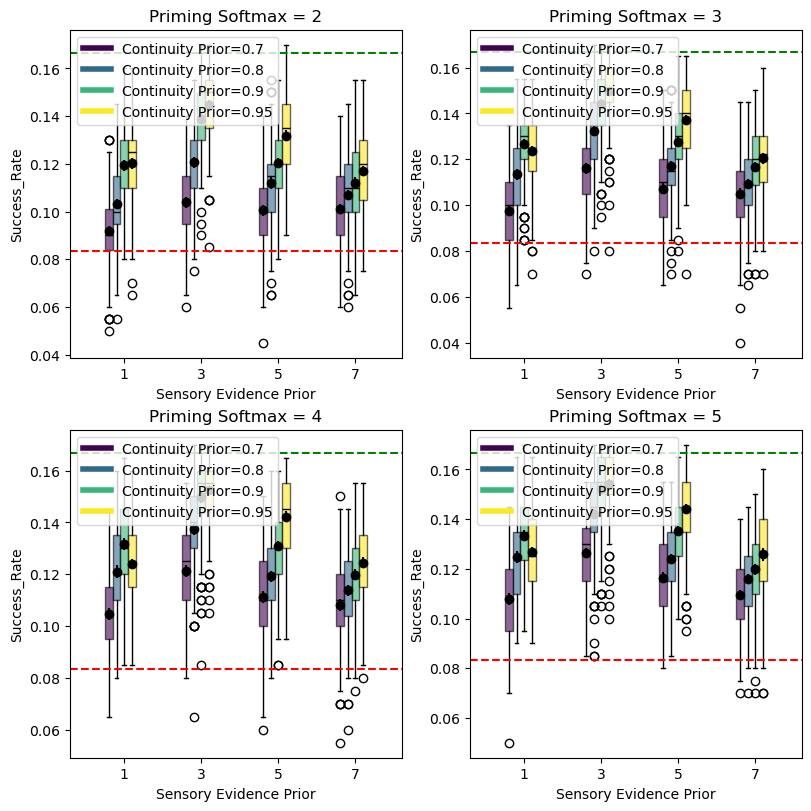

In [ ]:
mean_success = np.mean(observation_data_DR3[:,:,:,:,range(100,T),0], axis = 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

for i in range(np.shape(mean_success)[2]):
    ax = axes[i//2,i%2]
    plt.sca(ax)  # Set current axis
    simulation_boxplot_summary(mean_success[:,:,i,:], 
                               sensory_evidence_priors, 
                               continuity_priors, 
                               f'Priming Softmax = {action_softmax_temps[i]}',
                               "Success_Rate",
                               ["Sensory Evidence Prior", "Continuity Prior"]
                              )
    plt.axhline(y = 1/6, label = "Optimal", linestyle = "dashed", color = 'green')
    plt.axhline(y = 1/12, label = "Random Choce", linestyle = "dashed", color = 'red')

plt.show()

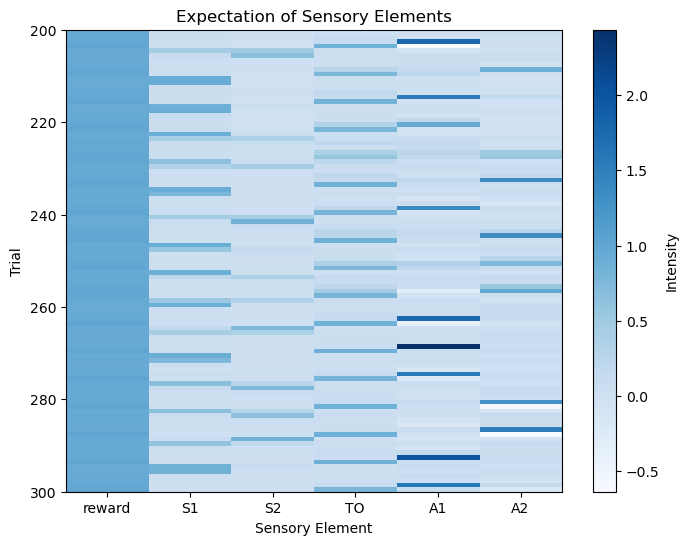

In [ ]:
plot_heatmap(sensory_expectations_DR3[1,2,3,0,range(200,300),:],
             extent = [0,6,300,200],
             ylabel = "Trial", 
             title = "Expectation of Sensory Elements", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"])

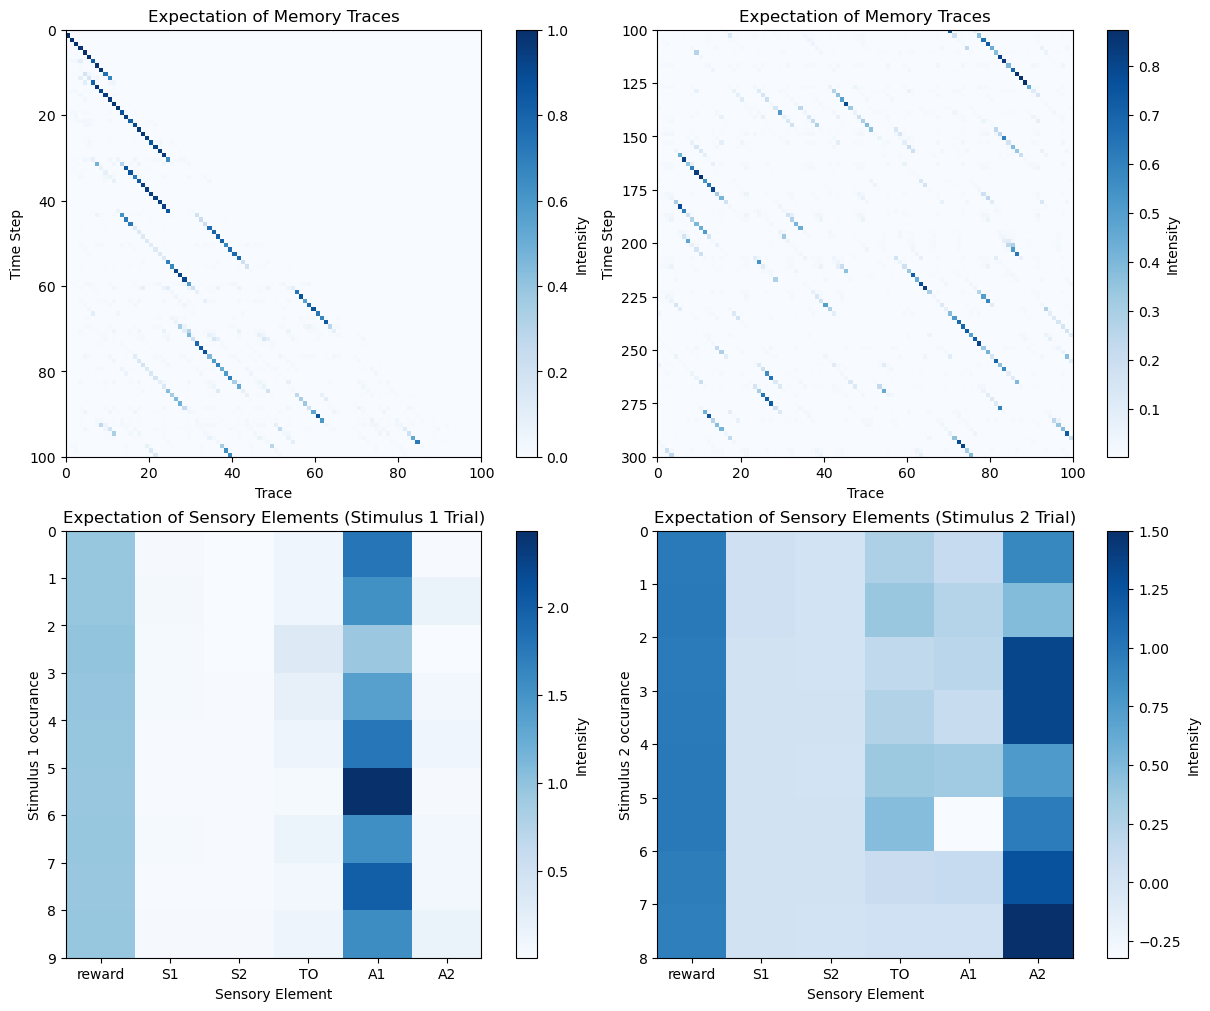

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), constrained_layout=True)

plot_heatmap(m_expectations_DR3[1,2,3,0,0:100,:], ax = axes[0,0])
plot_heatmap(m_expectations_DR3[1,2,3,0,200:300,:], extent = [0,100,300,100], ax = axes[0,1])
plot_heatmap(sensory_expectations_DR3[1,2,3,0,[t for t in range(200,300) if t % 6 == 4 and observation_data_DR3[1,2,3,0,t-3,1] == 1],:], #get test step, check 3 timesteps back for stimulus
             ylabel = "Stimulus 1 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 1 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,0])
plot_heatmap(sensory_expectations_DR3[1,2,3,0,[t for t in range(200,300) if t % 6 == 4 and observation_data_DR3[1,2,3,0,t-3,1] == 2],:], 
             ylabel = "Stimulus 2 occurance", 
             title = "Expectation of Sensory Elements (Stimulus 2 Trial)", 
             xlabel = "Sensory Element",
             xticks = [0.5,1.5,2.5,3.5,4.5, 5.5],
             xtick_labels = ["reward","S1","S2","TO","A1", "A2"],
             ax = axes[1,1])

plt.show()